In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import datetime as dt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import time

# Importing Data

## Import, Clean and Engineer Distance from NYC subway

In [2]:
sdf = pd.read_csv('data/subway_station_01.csv')

In [3]:
# seperate coordinates into two columns and deleted non numerical characters
sdf[['long', 'lat']] = sdf['the_geom'].str.rsplit(' ', 1, expand=True)
sdf['long'] = sdf['long'].str.replace('POINT \(','')
sdf['lat'] = sdf['lat'].str.replace('\)','')
sdf = sdf[['OBJECTID', 'lat', 'long']]

# zip ids, lats, and longs into a iterable list
ids = sdf['OBJECTID'].astype(int).tolist()
latitude = sdf['lat'].astype(float).tolist()
longitude = sdf['long'].astype(float).tolist()

stations = list(zip(ids, latitude, longitude))

In [4]:
from numpy import radians, cos, sin, arcsin, sqrt


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    r = 3956 # Radius of earth (6371 kilometers, 3956 miles)
    return c * r


def closest_station(lat, long):
    """ find distance to closest subway station """
    dist = 15
    for sid, slat, slong in stations:
        temp_dist = haversine(long, lat, slong, slat)
        dist = np.where(temp_dist < dist, temp_dist, dist)
    return dist

## Import and Clean Listing Data

In [5]:
df = pd.read_csv('data/listings.csv', dtype={'zipcode': 'category'}, low_memory=False)
df['subway_distance'] = closest_station(df['latitude'], df['longitude'])

Next we dropped empty, irrelevant, or unstructured data. There were also some features such as has_availability and is_business_travel_ready which were all the same value. 

In [6]:
keep_features = [
        'neighbourhood_cleansed',
        'neighbourhood_group_cleansed', 'state', 'subway_distance',
        'host_id', 'host_is_superhost', 'host_listings_count',
        'host_total_listings_count', 'host_verifications',
        'host_has_profile_pic', 'host_identity_verified', 'latitude',
        'longitude', 'is_location_exact', 'property_type', 'room_type',
        'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
        'security_deposit', 'cleaning_fee',
        'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
        'availability_30', 'availability_60',
        'availability_90', 'availability_365', 'calendar_last_scraped',
        'instant_bookable', 'cancellation_policy',
        'require_guest_profile_picture', 'require_guest_phone_verification',
        'calculated_host_listings_count', 'number_of_reviews','price'
    ]

# ndf = "new" df
ndf = df[keep_features].copy()

In [7]:
# convert dollar figures into float
monetary_features = ["security_deposit", "cleaning_fee" , "extra_people", "price"]

tdf = df[monetary_features].copy()
for col in monetary_features:
    tdf[col] = tdf[col].str.replace('$', '').str.replace(',','').astype(float)

ndf[monetary_features] = tdf
ndf[monetary_features].dtypes

security_deposit    float64
cleaning_fee        float64
extra_people        float64
price               float64
dtype: object

In [8]:
print(f"before cleaning: {set(ndf.state.values)}")
ndf['state'] = ndf['state'].str.upper()
ndf['state'] = np.where(ndf['state'] == 'NEW YORK', 'NY', ndf['state'])
ndf = ndf[ndf['state'] == 'NY']
print(f"after cleaning: {set(ndf.state.values)}")

before cleaning: {nan, 'CA', 'Ny', 'ny', 'NY', 'NJ', 'MP', 'New York'}
after cleaning: {'NY'}


In [9]:
ndf.isna().sum()

neighbourhood_cleansed                  0
neighbourhood_group_cleansed            0
state                                   0
subway_distance                         0
host_id                                 0
host_is_superhost                       8
host_listings_count                     8
host_total_listings_count               8
host_verifications                      0
host_has_profile_pic                    8
host_identity_verified                  8
latitude                                0
longitude                               0
is_location_exact                       0
property_type                           0
room_type                               0
accommodates                            0
bathrooms                              98
bedrooms                               56
beds                                   61
bed_type                                0
security_deposit                    19365
cleaning_fee                        12205
guests_included                   

Looking at the data we can see that empty values under `security_deposit` and `cleaning_fee` just refers to no fees, thus we will change them to zero.

In [10]:
ndf['security_deposit'] = ndf['security_deposit'].fillna(0)
ndf['cleaning_fee'] = ndf['cleaning_fee'].fillna(0)
ndf = ndf[keep_features].dropna()
ndf.shape

(50761, 39)

## removal of outliers

In [11]:
def remove_outliers(df,feature,low_value,high_value):
    df = df[df[feature]>low_value]
    df = df[df[feature]<=high_value]
    df.reset_index(drop=True,inplace=True)
    return df

In [12]:
ndf=remove_outliers(ndf,'price',0,1000)
ndf=remove_outliers(ndf,'maximum_nights',0,1200)
ndf=remove_outliers(ndf,'minimum_nights',0,500)
ndf.shape

(50457, 39)

## encoding categorical variables

In [13]:
def encode(odf):
    df = odf.copy()
    cat_features = list(df.columns[df.dtypes == 'object'])
    for i in  cat_features:
        df[i] = LabelEncoder().fit_transform(df[i])
    return df
fdf = encode(ndf)

In [14]:
# before encoding
ndf.head(3)

,neighbourhood_cleansed,neighbourhood_group_cleansed,state,subway_distance,host_id,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,number_of_reviews,price
0,Harlem,Manhattan,NY,0.097304,2758,t,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,40.799205,-73.953676,t,Apartment,Private room,3,1.0,1.0,3.0,Real Bed,0.0,60.0,2,39.0,2,21,8,8,27,287,2018-11-04,f,strict_14_with_grace_period,f,f,3,174,59.0
1,Kensington,Brooklyn,NY,0.289172,2787,t,8.0,8.0,"['email', 'phone', 'reviews', 'kba']",t,t,40.647486,-73.972370,f,Apartment,Private room,4,1.0,1.0,3.0,Real Bed,100.0,25.0,1,25.0,1,730,30,60,90,365,2018-11-04,f,moderate,f,f,8,9,149.0
2,Midtown,Manhattan,NY,0.057787,2845,f,5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,40.753621,-73.983774,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,350.0,100.0,2,0.0,1,1125,24,41,71,346,2018-11-04,f,strict_14_with_grace_period,t,t,2,38,225.0


In [15]:
# after encoding
fdf.head()

,neighbourhood_cleansed,neighbourhood_group_cleansed,state,subway_distance,host_id,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,number_of_reviews,price
0,97,2,0,0.097304,2758,1,3.0,3.0,84,1,1,40.799205,-73.953676,1,1,1,3,1.0,1.0,3.0,4,0.0,60.0,2,39.0,2,21,8,8,27,287,1,0,3,0,0,3,174,59.0
1,111,1,0,0.289172,2787,1,8.0,8.0,321,1,1,40.647486,-73.972370,0,1,1,4,1.0,1.0,3.0,4,100.0,25.0,1,25.0,1,730,30,60,90,365,1,0,1,0,0,8,9,149.0
2,130,2,0,0.057787,2845,0,5.0,5.0,320,1,1,40.753621,-73.983774,0,1,0,2,1.0,0.0,1.0,4,350.0,100.0,2,0.0,1,1125,24,41,71,346,1,0,3,1,1,2,38,225.0
3,166,1,0,0.833927,61531,0,3.0,3.0,321,1,1,40.676947,-74.011209,1,19,1,4,1.0,1.0,1.0,4,300.0,60.0,1,45.0,1,730,0,2,32,307,1,0,3,0,0,3,22,89.0
4,218,1,0,0.156763,4177,0,5.0,5.0,321,1,1,40.708558,-73.942362,1,1,1,2,1.0,1.0,1.0,4,150.0,125.0,2,50.0,5,730,0,13,14,186,1,0,3,0,0,3,36,70.0


## correlation

In [16]:
corr_matrix = fdf.corr()

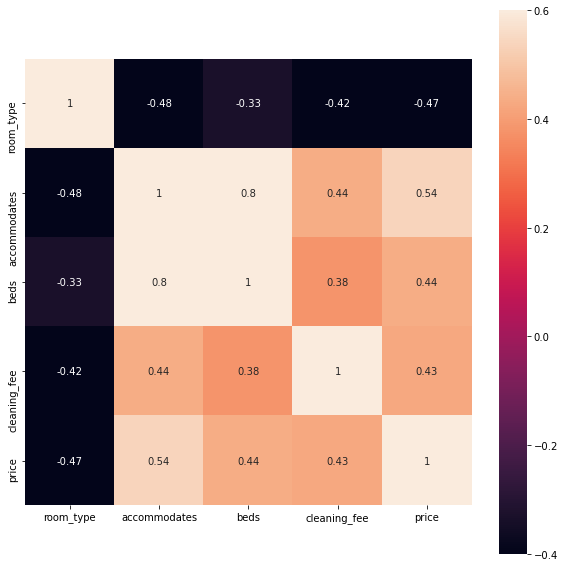

In [18]:
top_features = corr_matrix.index[abs(corr_matrix["price"])>0.4]
plt.figure(figsize=(10,10))
sns.heatmap(fdf[top_features].corr(), annot = True, cbar = True, vmin = -0.4, vmax = 0.6, square=True);

## Regression

In [19]:
R = RandomState(seed=1)
train = fdf.sample(frac=0.8, random_state=R)
test = fdf.loc[~fdf.index.isin(train.index)]

In [20]:
X_train=train.copy()
X_test=test.copy()
y_train = np.log1p(X_train['price'])
y_test  = np.log1p(X_test['price'])

drop_features=['price']
X_train.drop(drop_features,axis=1,inplace = True)
X_test.drop(drop_features,axis=1,inplace = True)

In [21]:
# Lasso
lasso = Lasso(max_iter = 10000)
param_grid =dict(alpha=np.logspace(-4,1,50))
grid_lasso = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error')

grid_lasso.fit(X_train, y_train)
print(f"grid.best_score_: {grid_lasso.best_score_}")
print(f"grid.best_params_: {grid_lasso.best_params_}")
print(f"grid.best_estimator_: {grid_lasso.best_estimator_}")

model_lasso = grid_lasso.best_estimator_


grid.best_score_: -0.1688956291527174
grid.best_params_: {'alpha': 0.0001}
grid.best_estimator_: Lasso(alpha=0.0001, max_iter=10000)


In [23]:
model = model_lasso
X = X_train
y = y_train


predictions = model.predict(X)
errors = abs(np.expm1(predictions) - np.expm1(y))
mape = 100 * np.mean(errors / np.expm1(y))
accuracy = 100 - mape
score_gbr = model.score(X,y)
rmse_gbr = np.sqrt(mean_squared_error(np.expm1(y),np.expm1(predictions)))

print('Training Set')
print(f'R^2: {score_gbr:.4f}')
print(f'RMSE: ${rmse_gbr:.2f} ')
print(f'Average Error: ${np.mean(errors):.2f}')
print(f'Accuracy = {accuracy:.2f}%.','\n')

model = model_lasso
X = X_test
y = y_test

predictions = model.predict(X)
errors = abs(np.expm1(predictions) - np.expm1(y))
mape = 100 * np.mean(errors / np.expm1(y))
accuracy = 100 - mape
score_gbr = model.score(X,y)
rmse_gbr = np.sqrt(mean_squared_error(np.expm1(y),np.expm1(predictions)))

print('Training Set')
print(f'R^2: {score_gbr:.4f}')
print(f'RMSE: ${rmse_gbr:.2f} ')
print(f'Average Error: ${np.mean(errors):.2f}')
print(f'Accuracy = {accuracy:.2f}%.')


Training Set
R^2: 0.6154
RMSE: $85.16 
Average Error: $44.86
Accuracy = 67.69%. 

Training Set
R^2: 0.6220
RMSE: $79.03 
Average Error: $43.41
Accuracy = 67.87%.
